# Predicting Flagellate production rate with a Histogram-based Gradient Boosting Regression Tree based on the oceanographic boxes

## Importing

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import r_regression

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

from tqdm import tqdm

import random

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi


## Datasets Preparation

In [ ]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, name, inputs_names, regions):

    dayofyear = np.tile(np.arange(0,len(dataset.time_counter)//len(np.unique(dataset.time_counter.dt.year))), len(np.unique(dataset.time_counter.dt.year)))

    inputs = []
    
    if 'Day_of_year' in inputs_names:   
        for i in inputs_names[0:inputs_names.index('Day_of_year')]:
            inputs.append(dataset[i].to_numpy().flatten())  

        inputs.append(np.repeat(dayofyear, len(dataset.x)*len(dataset.y)))

        for i in inputs_names[inputs_names.index('Day_of_year')+1:]:
            inputs.append(dataset[i].to_numpy().flatten()) 

    else:        
        for i in inputs_names:
            inputs.append(dataset[i].to_numpy().flatten())

    inputs = np.array(inputs)
    targets = np.ravel(dataset[name])

    regions = np.tile(np.ravel(regions), len(np.unique(dataset.time_counter)))

    indx = np.where(np.isfinite(targets) & ~np.isnan(regions))
    inputs = inputs[:,indx[0]]
    targets = targets[indx[0]]

    regions = regions[indx[0]]

    inputs = inputs.transpose()

    return(inputs, targets, indx, regions)


## Datasets Preparation 2

In [ ]:
# Creation of the data arrays
def datasets_preparation2(variable, name, units, dataset, indx):

    # Obtaining the daily indexes
    variable_all = np.full((len(dataset.time_counter) * len(dataset.y) * len(dataset.x)),np.nan)
    variable_all[indx[0]] = variable
    variable_all = np.reshape(variable_all,(len(dataset.time_counter),len(dataset.y),len(dataset.x)))

    # Preparation of the dataarray 
    array = xr.DataArray(variable_all,
        coords = {'time_counter': dataset.time_counter,'y': dataset.y, 'x': dataset.x},
        dims = ['time_counter','y','x'],
        attrs=dict(description= name,
        units=units))
        
    return (array)


## File Creation

In [ ]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 'targets_predictions.nc', mode='a', encoding={name:{"zlib": True, "complevel": 9}})
    temp.close()
    

## Regressor

In [ ]:
def regressor (inputs, targets, inputs_names, n_bins, i, r_inputs, indexes):

    spatial = []
    if 'Latitude' in inputs_names:
        spatial.append('Latitude')
    if 'Longitude' in inputs_names:
        spatial.append('Longitude')

    if spatial == []:
        if 'Day_of_year' not in inputs_names:

            model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
            transformers=[('drivers', StandardScaler(), np.arange(0,len(inputs_names)))]),
            HistGradientBoostingRegressor()),
            transformer=StandardScaler())

        else:

            model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
                transformers=[('drivers', StandardScaler(), np.arange(0,len(inputs_names)-1))], remainder='passthrough'),
                HistGradientBoostingRegressor(categorical_features=[len(inputs_names)-1])),
                transformer=StandardScaler())
        
    else:

        model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
        transformers=[('drivers', StandardScaler(), np.arange(0,inputs_names.index(spatial[0]))),
            ('spatial', KBinsDiscretizer(n_bins=n_bins,encode='ordinal',strategy='kmeans'), np.arange(inputs_names.index(spatial[0]),inputs_names.index(spatial[-1])+1))],
            remainder='passthrough'),
        HistGradientBoostingRegressor(categorical_features=np.arange(inputs_names.index(spatial[0]), len(inputs_names)))),
        transformer=StandardScaler())

    regr = model.fit(inputs,targets)

    r_inputs[i,indexes] = np.round(r_regression(inputs,targets),2)

    return(regr, r_inputs)


## Scatter Plot

In [ ]:
def scatter_plot(targets, predictions, name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, predictions, deg=1)

    fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

    ax[0].scatter(targets,predictions, alpha = 0.2, s = 10)

    lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

    # plot fitted y = m*x + b
    ax[0].axline(xy1=(0, b), slope=m, color='r')

    ax[0].set_xlabel('targets')
    ax[0].set_ylabel('predictions')
    ax[0].set_xlim(lims)
    ax[0].set_ylim(lims)
    ax[0].set_aspect('equal')

    ax[0].plot(lims, lims,linestyle = '--',color = 'k')

    h = ax[1].hist2d(targets,predictions, bins=100, cmap='jet', 
        range=[lims,lims], cmin=0.1, norm='log')
    
    ax[1].plot(lims, lims,linestyle = '--',color = 'k')

    # plot fitted y = m*x + b
    ax[1].axline(xy1=(0, b), slope=m, color='r')

    ax[1].set_xlabel('targets')
    ax[1].set_ylabel('predictions')
    ax[1].set_aspect('equal')

    fig.colorbar(h[3],ax=ax[1], location='bottom')

    fig.suptitle(name)

    plt.show()

    return(m)


## Plotting (Criteria)

In [ ]:
def plotting_criteria(dates, variable, year_variable, months, period, title):
    
    indx = pd.DatetimeIndex(dates)
    fig, ax = plt.subplots()

    scatter= ax.scatter(dates,variable, marker='.', c=indx.month)
    plt.xticks(rotation=70)
    ax.legend(handles=scatter.legend_elements()[0], labels=months)
    ax.plot(dates[(indx.month == np.unique(indx.month)[1]) & (indx.day == len(np.unique(dates.day)) // 2)], year_variable,color='red',marker='*')
    fig.suptitle(title + ' ' + period)
    
    plt.show()


## Plotting (Mean Values)

In [ ]:
def plotting_mean_values(dates, targets, predictions, r, rms, slope, units, category, period, boxnames, labels):

    temp = pd.DataFrame(np.vstack((r,rms,slope)).transpose(),columns=['r','rms [%]','slope'])
    display(temp)

    years = np.unique(dates.year)

    fig, ax = plt.subplots(figsize=(19,5))
    
    mean_targets = np.ma.array(targets)
    mean_predictions = np.ma.array(predictions)

    for year in years:
        mean_targets[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        mean_predictions[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        
    ax.plot(mean_targets, label = 'targets')
    ax.plot(mean_predictions, label = 'predictions')

    ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
    ticks = np.int16(ticks)
    labels2=np.tile(labels,len(years))

    ax.set_xticks(ticks, labels2[ticks])

    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
    
    ax2.tick_params(length=0, pad=30)

    plt.suptitle('Mean '+category + ' ' +units + ' ' + period + ' ' + boxnames)
    ax.legend()
    plt.show()


## Plotting (Paper)

In [ ]:
def plotting_paper(dates,targets,predictions,units,boxnames,period,labels,season,r_train,r_train_season,r_test,r_test_season,rms_train,rms_test):

    years = np.unique(dates.year)

    targets = targets.transpose()
    predictions = predictions.transpose()
    
    targets_masked = np.ma.array(targets)
    predictions_masked = np.ma.array(predictions)

    for year in years:
        targets_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        predictions_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked

    names = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

    k,l = 0,0
    fig, ax = plt.subplots(4, 3, figsize=(17, 15), layout='constrained')

    ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
    ticks = np.int16(ticks)
    labels2 = np.tile(labels,len(years))
    ax[k,l].set_xticks(ticks, labels2[ticks])

    test = np.arange(0,len(targets_masked))

    for j in np.arange (0,len(boxnames)):

        ax[k, l].plot(targets_masked[:,j])
        ax[k, l].plot(test[:ticks[-2]-1],predictions_masked[0:ticks[-2]-1,j])
        ax[k, l].plot(test[ticks[-2]:],predictions_masked[ticks[-2]:,j], color='tab:red')
        ax[k,l].fill_between((test[0],test[ticks[2]-2]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        ax[k,l].fill_between((test[ticks[4]-1],test[ticks[6]-2]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        ax[k,l].fill_between((test[ticks[-2]-1],test[-1]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')

        ax[k, l].set_title(boxnames[j])
        
        ax[k,l].annotate(names[j], (0.02, 0.9), xycoords='axes fraction', fontsize=14)

        ax2 = ax[k, l].secondary_xaxis('bottom')
        ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
        ax2.tick_params(length=0, pad=30)

        if l == 0:
            ax[k, l].set_ylabel(units +' (no seasonality)')

        l=l+1
        if l==3:
            l=0
            k=k+1

    fig.legend(['targets', 'predictions', '2025'], ncols=3)
    fig.suptitle('Mean NPR' + ' ' + period)

    ax[k, l].plot(season)
    ax[k, l].set_xticks(ticks=np.arange(0,len(labels),len(labels)//8+1), labels=labels[np.arange(0,len(labels),len(labels)//8+1)])
    ax[k, l].set_title('Long-term seasonalities (2007-2020)')
    ax[k, l].set_ylabel(units)
    ax[k, l].legend(boxnames, ncol=2)
    ax[k,l].annotate('(j)', (0.95, 0.05), xycoords='axes fraction', fontsize=14)

    l = l + 1
    ax[k, l].plot(r_train, label = 'R training', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(r_test[0], label = 'R evaluation', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(r_test[1], label = 'R testing', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(r_train_season, label = 'R training (no seasonality)', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(r_test_season[0], label = 'R evaluation (no seasonality)', marker = '.', ls = '', markersize=12)
    ax[k, l].plot(r_test_season[1], label = 'R testing (no seasonality)', marker = '.', ls = '', markersize=12)
    ax[k, l].set_xticks(ticks = np.arange(0, len(boxnames)), labels=boxnames)
    ax[k, l].set_title('Correlation coefficients')
    ax[k, l].legend(ncols=2)
    ax[k,l].annotate('(k)', (0.94, 0.15), xycoords='axes fraction', fontsize=14)
    ax[k, l].set_xlabel('Sub-regions')

    l = l + 1
    ax[k, l].plot(rms_train, label = 'RMSE training', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(rms_test[0], label = 'RMSE evaluation', marker = '.', ls = ' ', markersize=12)
    ax[k, l].plot(rms_test[1], label = 'RMSE testing', marker = '.', ls = ' ', markersize=12)
    ax[k, l].set_xticks(ticks = np.arange(0, len(boxnames)), labels=boxnames)
    ax[k, l].set_ylabel('[%]')
    ax[k, l].set_title('Root mean square errors')
    ax[k, l].legend()
    ax[k,l].annotate('(l)', (0.95, 0.05), xycoords='axes fraction', fontsize=14)
    ax[k, l].set_xlabel('Sub-regions')
    

## Plotting (Paper2)

In [ ]:
def plotting_paper2(targets_all,predictions_all,units,dates,r_days,rms_days,labels,period, minim, maxim):

    fig, ax = plt.subplots(1,3, figsize = (17,10), layout = 'tight')

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    targets_all.plot(ax=ax[0], cmap=cmap, vmin = minim, vmax = maxim, cbar_kwargs={'label': 'NPR' + ' ' + units})
    predictions_all.plot(ax=ax[1], cmap=cmap, vmin = minim, vmax = maxim, cbar_kwargs={'label': 'NPR' + ' ' + units})
    ((targets_all-predictions_all) / targets_all * 100).plot(ax=ax[2], cmap=cmap, cbar_kwargs={'label': 'NPR errors' + ' ' + '[%]'})

    sa_vi.set_aspect(ax[0])
    sa_vi.set_aspect(ax[1])
    sa_vi.set_aspect(ax[2])

    ax[0].annotate('(a)', (0.02, 0.97), xycoords='axes fraction', fontsize=14)
    ax[1].annotate('(b)', (0.02, 0.97), xycoords='axes fraction', fontsize=14)
    ax[2].annotate('(c)', (0.02, 0.97), xycoords='axes fraction', fontsize=14)

    ax[0].title.set_text('Targets')
    ax[1].title.set_text('Predictions')
    ax[2].title.set_text('Targets - Predictions')

    plt.suptitle('NPR daily maps ' +units + ', ' + '(' + str(targets_all.time_counter.dt.date.values) + ')')

    years = np.unique(dates.year)

    fig, ax = plt.subplots(figsize=(15,5))

    mean_r_days = np.ma.array(r_days)
    mean_rms_days = np.ma.array(rms_days)
    test = np.arange(0,len(mean_r_days))

    ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
    ticks = np.int16(ticks)
    labels2=np.tile(labels,len(years))

    for year in years:
        mean_r_days[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        mean_rms_days[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        
    ax.plot(mean_r_days, marker = '.')
    ax.fill_between((test[0],test[ticks[2]-2]), np.max(mean_r_days), alpha=0.3, color='grey')
    ax.fill_between((test[ticks[4]-1],test[ticks[6]-2]), np.max(mean_r_days), alpha=0.3, color='grey')
    ax.fill_between((test[ticks[-2]-1],test[-1]), np.max(mean_r_days), alpha=0.3, color='grey')
    
    ax.annotate('(d)', (0.005, 0.92), xycoords='axes fraction', fontsize=14)

    ax.set_xticks(ticks, labels2[ticks])
    ax.set_ylabel('Daily spatial R', color='tab:blue')

    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
    ax2.tick_params(length=0, pad=30)

    ax3 = ax.twinx()
    ax3.plot(mean_rms_days, marker = '.', color='tab:orange')
    ax3.set_ylabel('Daily spatial RMSE [%]', color='tab:orange')

    plt.suptitle('Daily spatial R and RMSE for NPR, ' + period)
    plt.show()

## Plotting (Maps)

In [ ]:
def plotting_maps(targets, predictions, name, units):

    fig, ax = plt.subplots(2,2, figsize = (10,15), layout='tight')

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    targets.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    predictions.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    (targets-predictions).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': name + ' ' + units})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text('Targets')
    ax[0,1].title.set_text('Predictions')
    ax[1,0].title.set_text('Targets-Predictions')
    ax[1,1].axis('off')

    fig.suptitle(name + ' '+ str(targets.time_counter.dt.date.values))

    plt.show()
    

## Plotting (Regions)

In [ ]:
def plot_box(ax, corn, colour):

    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
    [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)
    

## Plotting (Mean Peaks)

In [ ]:
def plotting_mean_peaks(dates,targets_mean,predictions_mean,category,units,region,boxname,labels):

    years = np.unique(dates.year)
    
    fig, ax = plt.subplots(figsize=(19,5))
    
    targets_mean = np.ma.array(targets_mean)
    predictions_mean = np.ma.array(predictions_mean)

    for year in years:
      
        targets_mean[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        predictions_mean[(np.where(dates.year==year)[0][-1])] = np.ma.masked

    ax.plot(targets_mean, label = 'targets')
    ax.plot(predictions_mean, label = 'predictions')

    ax.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)//len(years)+1), labels=np.tile(labels[np.arange(0,len(labels),len(labels)//len(years)+1)],len(years)))
    
    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)+1), labels=years)
    
    ax2.tick_params(length=0, pad=30)

    plt.suptitle('Mean '+category + ' ' +units + ' (15 Feb - 30 Apr) ' + region + ' ' + boxname)
    ax.legend()
    plt.show()
    

## Plotting (Regional analysis)

In [ ]:
def plotting_regional(metric,box,years,category):

    fig,ax = plt.subplots()

    for i in range (0,len(box)):
        ax.plot(years,metric[:,i],marker= '*', label=box[i])
    plt.suptitle(category+ ' (Regional analysis)')
    plt.legend()
    fig.show()


## Post - Processing

In [ ]:
def post_processing(targets,predictions):

    r = np.round(np.corrcoef(predictions,targets)[0][1],3)
    rms = rmse(predictions,targets)  / np.mean(targets) * 100
    m,_ = np.polyfit(targets, predictions, deg=1)
    slope = np.round(m,3)

    return(r,rms,slope)

## Evaluation

In [ ]:
def evaluation (dataset, dates, name, units, regr_all, regions0, boxes, unique_inputs_names, indexes):

    # For every year
    r_years = np.array([])
    rms_years = np.array([])
    slope_years = np.array([])

    inputs, targets, indx, regions  = datasets_preparation(dataset, name, unique_inputs_names, regions0)

    predictions = np.full(targets.shape,np.nan) # size of targets without nans

    std_targets_test = np.zeros(len(boxes))
    std_predictions_test = np.zeros(len(boxes))

    for i in range (0, len(boxes)):

        indx2 = np.where(regions==i)
        inputs2 = inputs[indx2[0],:][:,indexes[i]]
        targets2 = targets[indx2[0]]

        predictions[indx2[0]] = regr_all[i].predict(inputs2) 

        std_targets_test[i] = np.nanstd(targets2)
        std_predictions_test[i] = np.nanstd(predictions)

    targets_temp = np.split(targets,len(np.unique(dates.year)),axis=0)
    predictions_temp = np.split(predictions,len(np.unique(dates.year)),axis=0)

    for i in range (0, len(np.unique(dates.year))):

        # Calculating the annual time-series
        m_year = scatter_plot(targets_temp[i], predictions_temp[i], name + ' for ' + str(np.unique(dates.year)[i]))
        r_year = np.corrcoef(targets_temp[i], predictions_temp[i])[0][1]
        rms_year = rmse(targets_temp[i], predictions_temp[i]) / np.mean(targets_temp[i]) * 100

        r_years = np.append(r_years,r_year)
        rms_years = np.append(rms_years,rms_year)
        slope_years = np.append(slope_years,m_year)

    targets_all = datasets_preparation2(targets, name, units, dataset, indx)
    predictions_all = datasets_preparation2(predictions, name, units, dataset, indx)

    return(r_years, rms_years, slope_years, targets_all, predictions_all, targets, predictions, regions, std_targets_test, std_predictions_test)


## Initiation

In [ ]:
name = 'Flagellate_Production_Rate'
units = '[mmol N m-2 s-1]'
category = 'Production rates'

filename = '/data/ibougoudis/MOAD/files/inputs/jan_mar.nc'

inputs_names = [['Summation_of_solar_radiation', 'Mean_precipitation', 'Longitude'], 
    ['Summation_of_solar_radiation', 'Mean_precipitation', 'Latitude'],
    ['Summation_of_solar_radiation', 'Mean_precipitation', 'Latitude', 'Longitude'], 
    ['Summation_of_solar_radiation', 'Latitude', 'Longitude'], 
    ['Summation_of_solar_radiation', 'Latitude', 'Longitude'], 
    ['Summation_of_solar_radiation', 'Mean_precipitation', 'Latitude', 'Longitude'], 
    ['Summation_of_solar_radiation', 'Mean_precipitation', 'Latitude', 'Longitude'],
    ['Summation_of_solar_radiation', 'Mean_precipitation', 'Latitude', 'Longitude'], 
    ['Summation_of_solar_radiation', 'Mean_precipitation', 'Latitude', 'Longitude']]

unique_inputs_names = []
for i in inputs_names:
    unique_inputs_names.extend(i)
unique_inputs_names = list(set(unique_inputs_names))

n_bins = 255

if filename[35:42] == 'jan_mar': # 75 days, 1st period
    period = '(16 Jan - 31 Mar)'
    id = '1'
    months = ['January', 'February', 'March']

elif filename[35:42] == 'jan_apr': # 120 days, 2nd period
    period = '(01 Jan - 30 Apr)'
    id = '2'
    months = ['January', 'February', 'March', 'April']

elif filename[35:42] == 'feb_apr': # 75 days, 3rd period
    period = '(15 Feb - 30 Apr)'
    id = '3'
    months = ['February', 'March', 'April']

elif filename[35:42] == 'apr_jun': # 76 days, 4th period
    period = '(16 Apr - 30 Jun)'
    id = '4'
    months = ['April', 'May', 'June']

elif filename[35:42] == 'may_sep': # 153 days, 5th period
    period = '(01 May - 30 Sep)'
    id = '5'
    months = ['May', 'June', 'July', 'August', 'September']
   
ds = xr.open_dataset(filename)


## Regions

In [ ]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(ds[name][0], cmap=mycmap)
sa_vi.set_aspect(ax)

SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'm')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'c')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'w')
PS_all = [0, 200, 80, 320]
plot_box(ax, PS_all, 'm')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'r')

boxnames = ['GN','GC','FP','GS', 'HB', 'JdFW', 'JdFE', 'PSA', 'PSM']
fig.legend(boxnames)

boxes = [SoG_north,SoG_center,Fraser_plume,SoG_south,Haro_Boundary,JdF_west,JdF_east,PS_all,PS_main]

regions0 = np.full((len(ds.y),len(ds.x)),np.nan)

for i in range (0, len(boxes)):
    regions0[boxes[i][0]:boxes[i][1], boxes[i][2]:boxes[i][3]] = i

regions0 = xr.DataArray(regions0,dims = ['y','x'])

# Low resolution

# temp = []

# for i in boxes:
#     temp.append([x//5 for x in i])

# boxes = temp


## Training

In [ ]:
# Low resolution

# ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# regions0 = regions0.isel(y=(np.arange(regions0.y[0], regions0.y[-1], 5)), 
#     x=(np.arange(regions0.x[0], regions0.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))

labels = np.unique(dataset.time_counter.dt.strftime('%d %b'))
indx_labels = np.argsort(pd.to_datetime(labels, format='%d %b'))
labels = labels[indx_labels]

indexes = []
temp = []
for i in inputs_names:
    for j in i:
        temp.append(unique_inputs_names.index(j))
    indexes.append(temp)
    temp = []

inputs, targets, indx, regions = datasets_preparation(dataset, name, unique_inputs_names, regions0)

r_inputs = np.full((len(boxnames), len(unique_inputs_names)), np.nan)
regr_all = []
predictions = np.full(targets.shape,np.nan) # size of targets without nans

for i in range(0, len(boxes)):

    indx2 = np.where(regions==i)
    inputs2 = inputs[indx2[0]][:,indexes[i]]
    targets2 = targets[indx2[0]]
    
    regr, r_inputs = regressor(inputs2, targets2, inputs_names[i], n_bins, i, r_inputs, indexes[i])

    regr_all.append(regr)
    
    predictions[indx2[0]] = regr.predict(inputs2)

print('Metrics between input features and '+name)
temp = pd.DataFrame(r_inputs, index=boxnames, columns=unique_inputs_names)
display(temp)


## Time-series (Training)

In [ ]:
dates = pd.DatetimeIndex(dataset['time_counter'].values)

r_train, rms_train, slope_train = np.zeros(len(boxes)),  np.zeros(len(boxes)),  np.zeros(len(boxes))

season = np.zeros((len(boxes),len(labels)))

r_train_season, slope_train_season = np.zeros(len(boxes)), np.zeros(len(boxes))

peak, std_targets, std_season, std_predictions = np.zeros(len(boxes)), np.zeros(len(boxes)), np.zeros(len(boxes)), np.zeros(len(boxes))

for i in range(0, len(boxes)):

    indx2 = np.where(regions==i)
    targets2 = targets[indx2[0]]
    predictions2 = predictions[indx2[0]]

    targets_mean = np.reshape(targets2,(len(dataset.time_counter), len(targets2) // len(dataset.time_counter)))
    predictions_mean = np.reshape(predictions2,(len(dataset.time_counter), len(targets2) // len(dataset.time_counter)))

    targets_mean = np.mean(targets_mean,axis=1)
    predictions_mean = np.mean(predictions_mean,axis=1)

    season_temp = np.array(np.split(targets_mean,len(np.unique(dates.year)),axis=0))
    season[i,:] = np.mean(season_temp, axis=0)

    season_train = np.tile(season[i,:],len(np.unique(dates.year))) # Broadcasting season to all training years

    r_train[i], rms_train[i], slope_train[i] = post_processing(targets_mean, predictions_mean)
    plotting_mean_values(dates, targets_mean, predictions_mean, r_train[i], rms_train[i], slope_train[i], units, category, period, boxnames[i] + ' with seasonality', labels)

    r_train_season[i], _, slope_train_season[i] = post_processing(targets_mean-season_train, predictions_mean-season_train)
    plotting_mean_values(dates, targets_mean-season_train, predictions_mean-season_train, r_train_season[i], rms_train[i], slope_train_season[i], 
        units, category, period, boxnames[i] + ' no seasonality', labels)

    mean = np.mean(targets2)
    std_targets[i] = np.std(targets2)
    peak[i] = mean + 0*std_targets[i]
    
    std_season[i] = np.std(season[i])
    std_predictions[i] = np.std(predictions2)

plt.plot(season.transpose())
plt.legend(boxnames)
plt.suptitle('Long-term seasonalities (2007-2020)')
plt.show()


## Testing Years

In [ ]:
dataset = ds.sel(time_counter = slice('2021', '2025'))

dates = pd.DatetimeIndex(dataset['time_counter'].values)
years = np.unique(dataset.time_counter.dt.year)

r_years, rms_years, slope_years, targets_all, predictions_all, targets, predictions, regions, std_targets_test, std_predictions_test = evaluation(
    dataset, dates, name, units,regr_all, regions0, boxes, unique_inputs_names, indexes)

r_days = xr.corr(targets_all,predictions_all, dim=['x','y'])
rms_days = xs.rmse(targets_all,predictions_all, dim=['x','y'], skipna=True) / targets_all.mean(['y', 'x']) * 100
slope_days = xs.linslope(targets_all,predictions_all, dim=['x','y'], skipna=True)

# plotting_criteria(dates, r_days, r_years, months, period, 'Correlation Coefficients')
# plotting_criteria(dates, rms_days, rms_years, months, period, 'Root Mean Square Errors')
# plotting_criteria(dates, slope_days, slope_years, months, period, 'Slopes of the best fitting line')

# # Daily maps

# maps = random.sample(sorted(np.arange(0,len(targets_all.time_counter))),10)
# for i in maps:

#     idx = np.isfinite(np.ravel(targets_all[i]))
#     scatter_plot(np.ravel(targets_all[i])[idx], np.ravel(predictions_all[i])[idx], name + ' '+ str(targets_all[i].time_counter.dt.date.values))

#     plotting_maps(targets_all[i], predictions_all[i], name, units)

season_test = np.tile(season,len(np.unique(dates.year))) # Broadcasting season to all testing years

peak = np.reshape(np.tile(peak, len(np.unique(dates.year))), (len(boxes),len(np.unique(dates.year))), order='F') # Broadcasting peak to all testing years
peak = xr.DataArray(peak, coords = {'box': boxnames, 'year': years}, dims = ['box','year'])

fig2_indx = np.argmax(r_days.to_numpy())


## Standard deviations

In [ ]:
plt.plot(std_targets)
plt.plot(std_season)
plt.plot(std_targets_test)
plt.plot(std_targets-std_season)
plt.plot(std_targets_test-std_season)

plt.plot(std_predictions)
plt.plot(std_predictions_test)
plt.plot(std_predictions-std_season)
plt.plot(std_predictions_test-std_season)

plt.xticks(ticks=np.arange(0,len(boxes)), labels=boxnames)
plt.xticks(rotation=45)
plt.legend(('targets','season','targets_test','targets-season','targets_test-season','predictions','predictions_test','predictions-season','predictions_test-season'))
plt.suptitle('Standard Deviations for training-seasonanlity-testing')
plt.show()

plt.plot((std_targets_test-std_season)*100/std_targets_test)
plt.xticks(ticks=np.arange(0,len(boxes)), labels=boxnames)
plt.xticks(rotation=45)
plt.suptitle('Percentage of difference between testing')


## Time-series (Testing)

In [ ]:
r_test,rms_test,slope_test = np.zeros((2,len(boxes))), np.zeros((2,len(boxes))), np.zeros((2,len(boxes)))

r_test_season, slope_test_season = np.zeros((2,len(boxes))), np.zeros((2,len(boxes)))

targets_sum, predictions_sum  = np.zeros((len(boxes),len(np.unique(dates.year)))), np.zeros((len(boxes),len(np.unique(dates.year))))

targets_mean, predictions_mean = np.zeros((len(boxes),len(np.unique(dates.year)))), np.zeros((len(boxes),len(np.unique(dates.year))))

targets_diff, predictions_diff = np.zeros((len(boxes),len(season[0])*len(np.unique(dates.year)))), np.zeros((len(boxes),len(season[0])*len(np.unique(dates.year))))

targets_test, predictions_test = np.zeros((len(boxes), len(np.unique(dates)))), np.zeros((len(boxes), len(np.unique(dates))))

rss = np.zeros(len(boxes))

for i in range (0, len(boxes)):

    targets = targets_all.where(regions0==i).mean(['y','x'])
    predictions = predictions_all.where(regions0==i).mean(['y','x'])

    targets_test[i] = targets
    predictions_test[i] = predictions

    targets_temp = targets.sel(time_counter = slice('2021', '2024'))
    predictions_temp = predictions.sel(time_counter = slice('2021', '2024'))

    r_test[0,i], rms_test[0,i], slope_test[0,i] = post_processing(targets_temp,predictions_temp)
    r_test_season[0,i], _, slope_test_season[0,i] = post_processing(targets_temp-season_test[i,0:len(targets_temp)],predictions_temp-season_test[i,0:len(targets_temp)])

    targets_temp = targets.sel(time_counter = slice('2025', '2025'))
    predictions_temp = predictions.sel(time_counter = slice('2025', '2025'))

    r_test[1,i], rms_test[1,i], slope_test[1,i] = post_processing(targets_temp,predictions_temp)
    r_test_season[1,i], _, slope_test_season[1,i] = post_processing(targets_temp-season_test[i,300:],predictions_temp-season_test[i,300:])

    targets_sum[i] = (targets-season_test[i]).groupby(targets.time_counter.dt.year).sum().values
    predictions_sum[i] =  (predictions-season_test[i]).groupby(predictions.time_counter.dt.year).sum().values

    targets_mean[i] = (targets-season_test[i]).groupby(targets.time_counter.dt.year).mean().values
    predictions_mean[i] =  (predictions-season_test[i]).groupby(predictions.time_counter.dt.year).mean().values

    rss[i] = ((targets-predictions)**2).sum().values # Similar to rms, is not affected by the seasonality

    plotting_mean_values(dates, targets-season_test[i], predictions-season_test[i], r_test_season[0,i], rms_test[0,i], slope_test_season[0,i],
        units, category, boxnames[i] +' (removed seasonality)', period, labels)
    
    targets_diff[i] = (targets).groupby(targets.time_counter.dt.year).where((targets).groupby(targets.time_counter.dt.year)>peak[i])
    predictions_diff[i] = (predictions).groupby(predictions.time_counter.dt.year).where((predictions).groupby(predictions.time_counter.dt.year)>peak[i])

    # plotting_mean_peaks(dates,targets_diff[i],predictions_diff[i],category,units,'Peaks',boxnames[i],labels)
    

## Figure 1

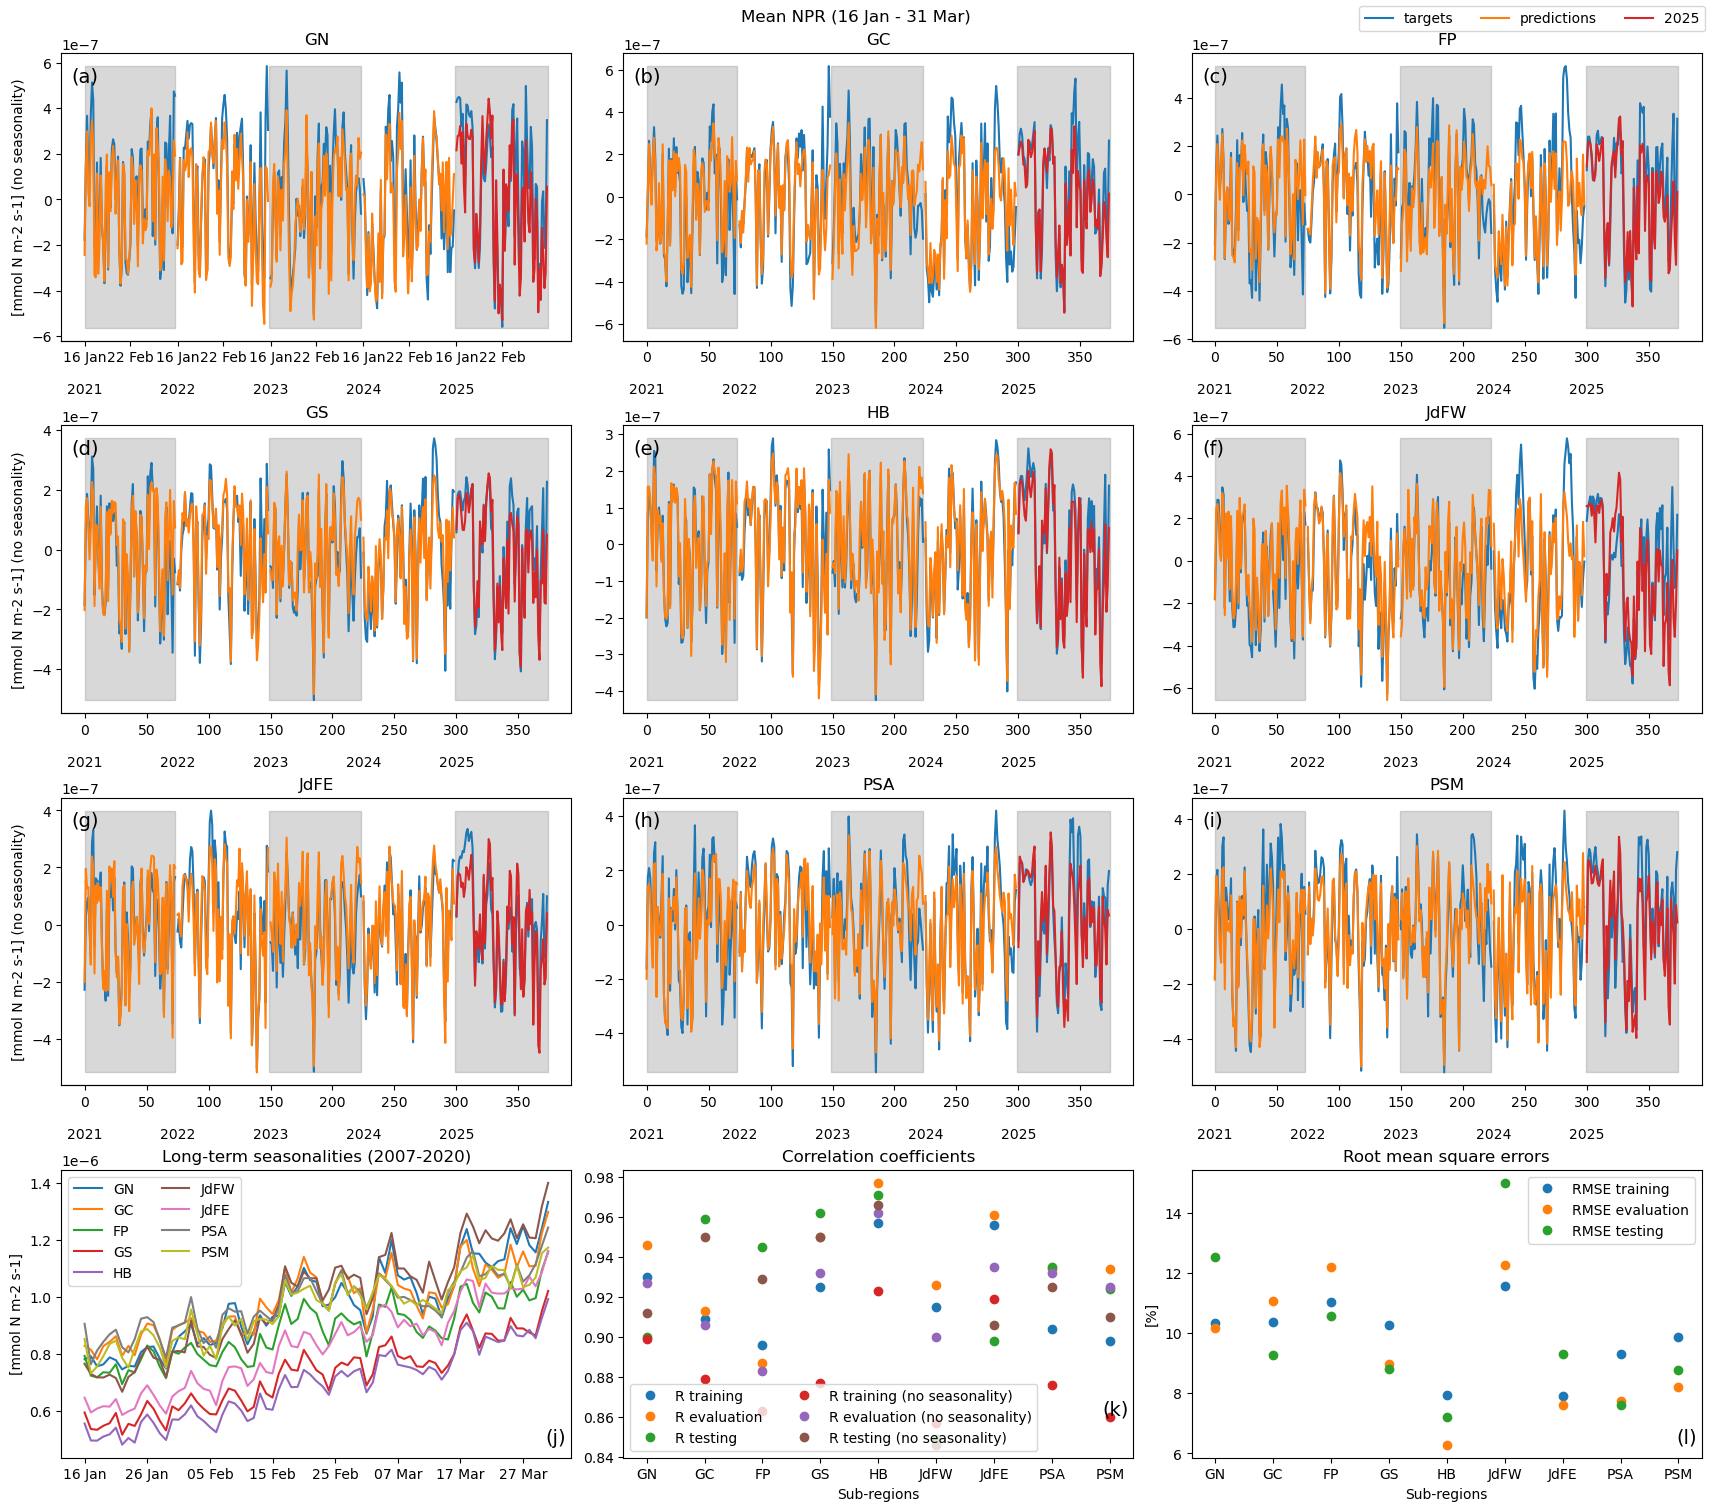

In [28]:
plotting_paper(dates,targets_test-season_test,predictions_test-season_test,units,boxnames,period,labels,season.transpose(),
    r_train,r_train_season,r_test,r_test_season,rms_train,rms_test)

## Figure 2

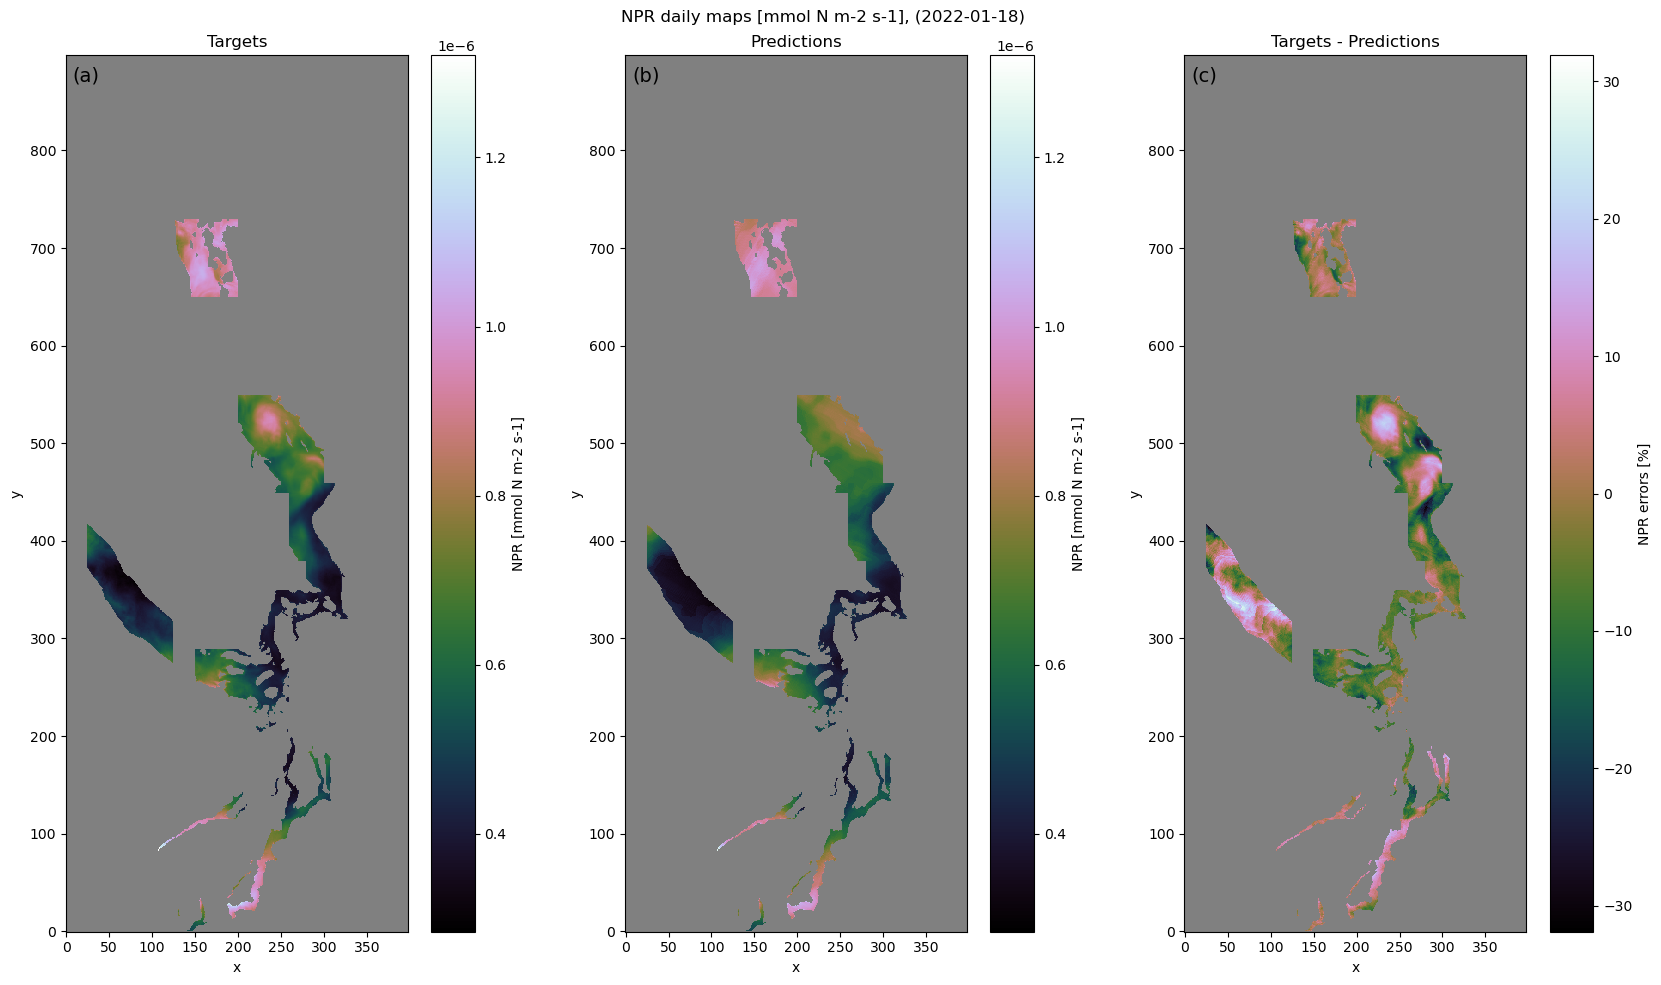

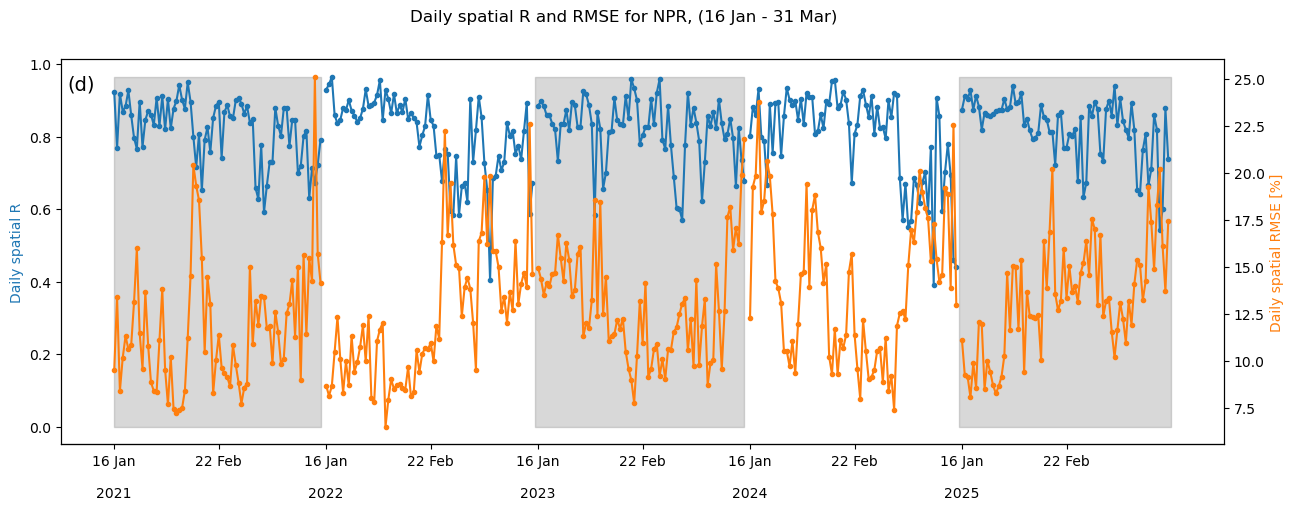

In [29]:
plotting_paper2(targets_all[fig2_indx],predictions_all[fig2_indx],units,dates,r_days,rms_days,labels,period, targets_all[fig2_indx].min(), targets_all[fig2_indx].max())

## Saving

In [27]:
path = '/data/ibougoudis/MOAD/files/results/' + name + '/single_runs/' + name[0:4].lower() + '_pr_hist' + id + '_boxes_f/'

os.makedirs(path, exist_ok=True)
with lzma.open(path + 'regr_all.xz', 'wb') as f:   
    dill.dump(regr, f)

with open(path + 'r_inputs.pkl', 'wb') as f:
    dill.dump(r_inputs, f)

with open(path + 'train_metrics.pkl', 'wb') as f:
    dill.dump([r_train,rms_train,slope_train,r_train_season,slope_train_season,season.transpose()], f)

with open(path + 'test_metrics.pkl', 'wb') as f:
    dill.dump([r_test,rms_test,slope_test,r_test_season,slope_test_season,targets_sum,predictions_sum,targets_mean,predictions_mean,targets_diff,predictions_diff,rss], f)

with open(path + 'figure1.pkl', 'wb') as f:
    dill.dump([dates,targets_test-season_test,predictions_test-season_test,units,boxnames,period,labels,season, r_train,r_train_season,r_test,r_test_season,rms_train,rms_test], f)

with open(path + 'figure2.pkl', 'wb') as f:
    dill.dump([targets_all[fig2_indx],predictions_all[fig2_indx],units,dates,r_days,rms_days,labels,period, targets_all[fig2_indx].min(), targets_all[fig2_indx].max()], f)

# file_creation(path, targets_all, 'Targets')
# file_creation(path, predictions_all, 'Predictions')
# file_creation(path, (targets_all-predictions_all), 'Targets - Predictions')

with open(path + 'readme.txt', 'w') as f:
    f.write ('name: ' + name)
    f.write('\n')
    f.write('period: ' + filename[35:42])
    f.write ('\n')
    f.write ('input_features: ')
    f.write (str([i for i in inputs_names]))
    f.write ('\n')
    f.write('n_bins: ' + str(n_bins))
    f.write ('\n')
